In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.constants as spc
from scipy.integrate import quad
import pandas as pd
from numba import jit

'''
Need to move this to a .py script later on!
'''

'\nNeed to move this to a .py script later on!\n'

In [19]:
'''
loading datafiles
'''

class spectrum_singleGas(object):

    def __init__(self):
        print('Reading the excel file.')
        self.excel_file = pd.read_excel("Venus Atmosphere.xlsx")

    def setParams(self, text_file):
        f = np.loadtxt(text_file, delimiter=',')
        molecule_id = f[:, 0]
        print('I am molecule ID is '+str(molecule_id[0])+ ' taken from HITRAN database')
        
        isotopologue_id = f[:, 1]
        print('My isotopologue ID is '+str(isotopologue_id[0])+ ' taken from HITRAN database')
        
        self.v_center = f[:, 2]
        self.S_0 = f[:, 3]
        self.delta_air = f[:, 4]
        self.alphaLorentz_a = f[:, 5]
        self.alphaDoppler_s = f[:, 6]
        self.gamma = f[:, 7]
        self.E_l = f[:, 8]
        
        self.v_center = self.v_center[0:100]
        self.S_0 = self.S_0[0:100]
        self.delta_air = self.delta_air[0:100]
        self.alphaLorentz_a = self.alphaLorentz_a[0:100]
        self.alphaDoppler_s = self.alphaDoppler_s[0:100]
        self.gamma = self.gamma[0:100]
        self.E_l = self.E_l[0:100]
        
        if molecule_id[0] == 5.0:
            molecule = self.excel_file.CO
        if molecule_id[0] == 22.0:
            molecule = self.excel_file.N2
        if molecule_id[0] == 9.0:
            molecule = self.excel_file.SO2
        if molecule_id[0] == 1.0:
            molecule = self.excel_file.H2O
        if molecule_id[0] == 2.0:
            molecule = self.excel_file.CO2
   
        self.q = molecule[0]
        self.m = molecule[1]
        self.coeff1 = molecule[2] 
        self.coeff2 = molecule[3]
        self.coeff3 = molecule[4]
        self.coeff4 = molecule[5]
        
        self.pressure = 10
        self.temperature = 300
        self.path_length = 5 #[km] this is fixed parameter
        
        return self.v_center
        
    def doppler_broadening(self):
        '''
        For pressures less than 0.1 atm, altitudes below 16 km
        '''
        T = self.temperature
        v_center = self.v_center
        m = self.m
        sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
        alpha_doppler = v_center*sqrt
        return alpha_doppler 
    
    def lorentz_broadening(self):
        P, T = self.pressure, self.temperature
        P_0, T_0 = 1, 296                         #[atm, K]
        alphaLorentz_a = self.alphaLorentz_a
        alphaLorentz_s = self.alphaDoppler_s
        q = self.q
        gamma = self.gamma 
        pressureRatio = P/P_0
        tempRatio = T_0/T
        alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
        return alpha_lorentz
    
    def voigt_profile_substitute(self,v):
        v_c = self.v_center
        if self.pressure > 0.1:
            alpha = self.lorentz_broadening()
            a = ((v - v_c)/alpha)**2
            f = 1/(np.pi*alpha*(1+a))
            return f
        else:
            alpha = self.doppler_broadening()
            sigma = alpha*2/2.355
            a = ((v - v_c)/4*sigma)**2
            f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
            return f
    
    def line_shape(self, v):
        T = self.temperature
        v_center = self.v_center 
        f = self.voigt_profile_substitute(v)
        tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
        tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
        g = v * tanh * f/(v_center*tanh_center)
        return g
    
    def total_internal_partition(self):
        '''
        Valid only for temeratures between 70-565K
        '''
        T = self.temperature
        a, b, c, d = self.coeff1, self.coeff2, self.coeff3, self.coeff4
        Q = a + b*T + c*T**2 + d*T**3
        return Q
                
    def line_intensity(self):
        T = self.temperature
        v_center = self.v_center
        S_0, T_0 = self.S_0, 296
        Q_T = self.total_internal_partition()
        Q_T0 = 107.42
        E_l = self.E_l
        exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
        exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
        exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        S = S_0*Q_T0*exp_lower*exp_center/(Q_T*exp_lower0*exp_center0)
        return S
        
    def transmittance(self, v):
        P = self.pressure
        T = self.temperature
        x = self.path_length
        q = self.q
        g = self.line_shape(v)
        S = self.line_intensity()
        numerator = -q*P*x*S*g
        denominator = spc.Boltzmann * T
        tau = np.exp(numerator/denominator)
        return tau
    
    

In [20]:
a = spectrum_singleGas()

Reading the excel file.


In [21]:
v_centers = a.setParams('CO.txt')

I am molecule ID is 5.0 taken from HITRAN database
My isotopologue ID is 1.0 taken from HITRAN database


In [22]:
select = v_centers[0:10]

In [25]:
vals = ([])
i = 0
for center in v_centers:
    v = np.arange(center-100, center+100, 1)
    for wavenumber in v:
        tau = a.transmittance(wavenumber)
        vals = np.append(vals, tau)
    print(i)   
    i = i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


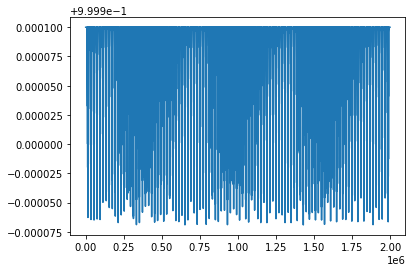

In [29]:
plt.plot(vals)

In [23]:
a = spectrum_singleGas()

Reading the excel file.


In [28]:
a.setParams('N2.txt')

I am molecule ID 22.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database


In [17]:
v_center, S_0, delta_ait, alphaLorentz_a, alphaDoppler_s, gamma, E_l = get_params('CO.txt')

I am molecule ID 5.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database, that means I am the most abundant topologue


In [ ]:
'''
Pressure profile numbers
'''
0.03114759459223761, 99.88052581859645
0.04262541256340627, 98.93404132848241
0.07396330468192495, 96.72792770958246
0.11301339760002972, 95.15173882029576
0.24864588317020964, 92.209556282034
0.3930284488717709, 90.4235026480965
0.5954637653326739, 88.74271188214527
0.9654835333099134, 86.53747958500763
1.984897261790517, 83.17733020096892
2.981859058125867, 81.39193755835316
4.404246790234677, 79.71147728806278
7.707288763992225, 76.87698125263366
12.286455656692105, 74.46254520216698
20.09085512084656, 71.94306661415459
34.861505127091675, 68.89925666017612
57.980570316010635, 66.17013365795353
97.25257399727431, 63.33618844862584
143.6433877390448, 61.23688001079621
219.48217918303857, 58.92770682831578
387.3570995946821, 55.98838858578154
655.2581246199782, 52.63077300180948
1053.4639388558178, 49.273818409159155
1812.5296226833775, 45.39242228532242
2566.0096489281436, 42.77010446417015
3790.031500384198, 39.3095394818379
6632.431966086814, 33.85724239928835
10220.419000618213, 29.453718213891293
16431.452663623844, 23.688386657890177
21921.649246600668, 20.54327978385585
29999.727280369407, 16.560146079082116
39685.54042726621, 12.472740993304711
62729.96036732756, 6.184069558320104
91095.097001193, 0.10592385930800674

In [ ]:
'''
Temperature Profiles
'''

166.07142857142856, 99.79035639412999
173.6344537815126, 94.33962264150945
181.19747899159665, 90.04192872117402
191.5966386554622, 85.95387840670861
201.99579831932772, 83.12368972746333
216.17647058823528, 79.45492662473796
230.35714285714283, 77.04402515723271
236.34453781512605, 75.36687631027254
238.8655462184874, 74.42348008385746
240.75630252100837, 72.8511530398323
242.96218487394958, 70.44025157232706
244.22268907563023, 67.9245283018868
242.33193277310926, 66.03773584905662
244.8529411764706, 63.94129979035641
247.3739495798319, 62.8930817610063
248.94957983193274, 61.94968553459121
245.16806722689074, 60.69182389937108
240.44117647058823, 59.433962264150956
239.18067226890756, 58.595387840670874
240.12605042016804, 57.75681341719079
242.96218487394958, 57.65199161425578
246.74369747899158, 57.12788259958072
249.89495798319325, 56.813417190775695
299.0546218487395, 52.201257861635234
322.37394957983196, 49.68553459119499
353.57142857142856, 45.91194968553461
404.30672268907557, 40.25157232704403
436.13445378151255, 36.68763102725369
468.90756302521004, 32.9140461215933
504.516806722689, 29.035639412997924
536.6596638655462, 25.262054507337538
559.9789915966386, 22.641509433962284
599.6848739495798, 17.610062893081775
627.4159663865546, 14.150943396226424
648.844537815126, 11.320754716981142
681.9327731092437, 6.708595387840688
725.7352941176471, 1.257861635220138
733.9285714285713, 0

In [6]:
f = np.loadtxt('/Users/akank/Downloads/CO.txt', delimiter=',')
#print(f.read())
#f.close()

In [7]:
f.shape

(1344, 9)

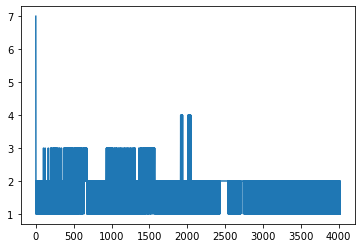

In [25]:
x = []
for y in f.read().split(','):
    print(y)
    if y.isdigit():
        x.append(float(y))

plt.plot(x)

In [4]:
'''
Conventions 

v = wavenumber[cm^-1] --- number if waves per cm. v = f/c
tau = transmittance --- ratio of transmitted radiance to incident radiance
epsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature
alpha = absorptivity --- fraction of incident radiance at v that is absorbed
g = line shape
f = voigt profile
S = line intesity
alpha_doppler =
alpha_lorentz = 
v_center = 
E_l = 
T_0 = 296K
P_0 = 1atm

'''

'''
Parameters

v = give a list of values to calculate(spectral range)

'''

'\nConventions \n\nv = wavenumber[cm^-1] --- number if waves per cm. v = f/c\ntau = transmittance --- ratio of transmitted radiance to incident radiance\nepsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature\nalpha = absorptivity --- fraction of incident radiance at v that is absorbed\n\n'

In [9]:
def wavenumber_center(pressure):
    P_0 = 1 #[atm] 
    pressureRatio = pressure/P_0
    #delta = 
    #v_0 =
    v_center = v_0 + delta*pressureRatio
    return v_center

def doppler_broadening(temperature):
    '''
    For pressures less than 0.1 atm, altitudes below 16 km
    '''
    T = temperature
    v_center = wavenumber_center(pressure) 
    #m = 
    sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
    alpha_doppler = v_center*sqrt
    return alpha_doppler
    
def lorentz_broadening(pressure, temperature):
    P, T = pressure, temperature
    P_0 = 1 #[atm] unsure
    T_0 = 296 #[K]
    #alphaLorentz_a = 
    #alphaLorentz_s = 
    #q = 
    #gamma = 
    pressureRatio = P/P_0
    tempRatio = T_0/T
    alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
    return alpha_lorentz

def integral_func(t, a, b):
    val = np.exp(-t**2)/((a - t)**2 + b**2)
    return val
    
def voigt_profile():
    alpha_doppler = doppler_broadening(pressure, temperature)
    alpha_lorentz = lorentz_broadening(temperature)
    #v = 
    v_center = wavenumber_center(pressure)  
    a = (v - v_center)/alpha_doppler
    b = alpha_lorentz/alpha_doppler
    integral = quad(integral_func, -np.inf, np.inf, )
    f = b*integral /(alpha_doppler*np.sqrt(np.pi)*np.pi)
    return f

def line_shape():
    #v =
    v_center = wavenumber_center(pressure)  
    f = voigt_profile()
    tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
    tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
    g = v * tanh * f/(v_center*tanh_center)
    return g

def line_shape(pressure):
    if pressure > 0.1:
        alpha = lorentz_broadening(pressure, temperature)
        a = ((v - v_c)/alpha)**2
        f = 1/(np.pi*alpha*(1+a))
        return f
    else:
        alpha = doppler_broadening(temperature)
        sigma = alpha*2/2.355
        a = ((v - v_c)/4*sigma)**2
        f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
        return f
    
def line_intensity(temperature):
    T = temperature
    v_center = wavenumber_center(pressure)
    #S_0, T_0 = ,296
    #Q_v, Q_r = 
    #Q_v0, Q_r0 =
    #E_l = 
    exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
    exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
    exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    S = S_0*Q_v0*Q_r0*exp_lower*exp_center/(Q_v*Q_r*exp_lower0*exp_center0)
    return S
    
def transmittance(pressure, temperature):
    P = pressure
    T = temperature
    #x = 
    #q = 
    g = line_shape()
    S = line_intensity(temperature)
    numerator = -q*P*x*S*g
    denominator = spc.Boltzmann * T
    tau = np.exp(numerator/denominator)
    return tau